In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize


#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import mfcc data

In [2]:
#choose which dictionary to use
choice = 'mfcc'#'spectro'


selected = 0
if choice == 'mfcc':
    
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    
    #name format of the selected data
    #name = 'variables/mfcc_D_DD_Dict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    name = 'variables/logfiltDict[nF=26 wL=0.025 wS=0.01].pkl'
    #saving in usedDict of the mfcc dict
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'spectro':
    
    #saving in usedDict of the spectro dict
    with open('variables/spectroDict.pkl', 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded spectroram')

Loaded variables/logfiltDict[nF=26 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [3]:
%%time
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test = ["yes", "up", "down", "left"]#, "right", "on", "off", "stop", "go", "zero",
          # "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = words

used.append('silence')
unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')

#divding between train and test with also scaling data
x_train, y_train, x_test, y_test, labelList = functions.train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = True,
    scalerType = 'robust',
    depth = 3)


{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
Wall time: 1min 7s


# Fitting

In [5]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.7
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 40
epochSGD = 20

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [5]:
cnn = models.model1(x_train,y_train, depth = 3)
print("Model1")
cnn.summary()

cnn = models.model2(x_train,y_train, depth = 3)
print("Model2")
cnn.summary()

cnn = models.model3(x_train,y_train, depth = 3)
print("Model3")
cnn.summary()

cnn = models.tinyDarknet(x_train,y_train, depth = 3)
print("tiny darknet")
cnn.summary()

Model1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 23, 64)        5440      
_________________________________________________________________
batch_normalization_1 (Batch (None, 93, 23, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 10, 128)       65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 10, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 8, 256)        393472    
___

ValueError: This model has never been called, thus its weights have not yet been created, so no summary can be displayed. Build the model first (e.g. by calling it on some test data).

In [15]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/300), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
cnn.save(dest_directory + name)

MODEL1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 93, 23, 64)        1856      
_________________________________________________________________
batch_normalization_56 (Batc (None, 93, 23, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 31, 11, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 31, 11, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 10, 128)       65664     
_________________________________________________________________
batch_normalization_57 (Batc (None, 28, 10, 128)       512       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 25, 8, 256)        393472    
___

KeyboardInterrupt: 


MODEL3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 96, 25, 16)        400       
_________________________________________________________________
activation_43 (Activation)   (None, 96, 25, 16)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 96, 25, 32)        2080      
_________________________________________________________________
activation_44 (Activation)   (None, 96, 25, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 96, 25, 64)        8256      
_________________________________________________________________
activation_45 (Activation)   (None, 96, 25, 64)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 96, 25, 64)        256       
__

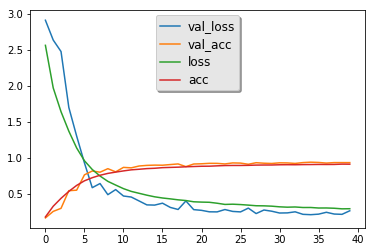

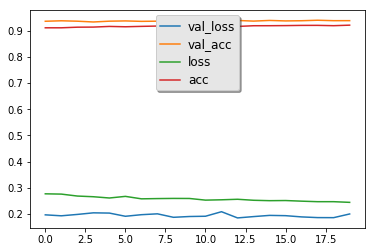

Wall time: 19min 53s


In [12]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train, depth = 3)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
cnn.save(dest_directory + name)


TINYDARKNET
Train on 40451 samples, validate on 10113 samples
Epoch 1/40
40451/40451 [==============================] - 26s 643us/step - loss: 2.0902 - acc: 0.5256 - val_loss: 0.8551 - val_acc: 0.7879
Epoch 2/40
40451/40451 [==============================] - 21s 521us/step - loss: 0.6685 - acc: 0.8062 - val_loss: 0.4549 - val_acc: 0.8658
Epoch 3/40
40451/40451 [==============================] - 21s 521us/step - loss: 0.4854 - acc: 0.8490 - val_loss: 0.4346 - val_acc: 0.8808
Epoch 4/40
40451/40451 [==============================] - 21s 520us/step - loss: 0.4209 - acc: 0.8710 - val_loss: 0.4799 - val_acc: 0.8672
Epoch 5/40
40451/40451 [==============================] - 21s 521us/step - loss: 0.3765 - acc: 0.8859 - val_loss: 0.3594 - val_acc: 0.9049
Epoch 6/40
40451/40451 [==============================] - 21s 521us/step - loss: 0.3471 - acc: 0.8949 - val_loss: 0.3739 - val_acc: 0.9023
Epoch 7/40
40451/40451 [==============================] - 21s 522us/step - loss: 0.3317 - acc: 0.8987 -

Epoch 19/20
40451/40451 [==============================] - 20s 500us/step - loss: 0.0649 - acc: 0.9790 - val_loss: 0.2451 - val_acc: 0.9381
Epoch 20/20
40451/40451 [==============================] - 20s 501us/step - loss: 0.0647 - acc: 0.9794 - val_loss: 0.2886 - val_acc: 0.9311


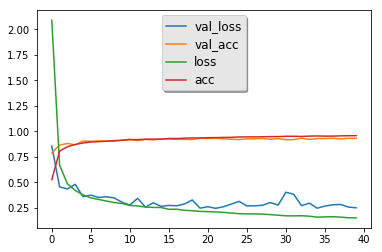

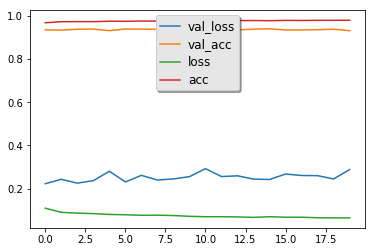

Wall time: 21min 7s


In [6]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train, depth = 3, dropout = 0.15)
#cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
cnn.save(dest_directory + name)

In [ ]:
#!tensorboard --logdir Graph/

In [34]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
input_img = Input(shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

def cBN(name, inputLayer, filt = 64, size = (1,1), padding = 'same', activation = 'relu'):
    cbn = Conv2D(filt, size, padding=padding, name = name, use_bias=False)(inputLayer)
    cbn = BatchNormalization()(cbn)
    cbn = Activation('relu')(cbn)
    return cbn

tower_1 = cBN('tower_11',input_img)   
tower_1 = cBN('tower_12',tower_1, size = (3,3))

tower_2 = cBN('tower_21',input_img)
tower_2 = cBN('tower_22',tower_2, size = (5,5))

tower_3 = MaxPooling2D((3,3), name = 'tower_31', strides=(1,1), padding='same')(input_img)
tower_3 = cBN('tower_32',tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = MaxPooling2D(pool_size=(4,3))(output)

tower_1 = cBN('tower_11_2',output)   
tower_1 = cBN('tower_12_2',tower_1, size = (3,3))

tower_2 = cBN('tower_21_2',output)
tower_2 = cBN('tower_22_2',tower_2, size = (5,5))

tower_3 = MaxPooling2D( (3,3),name = 'tower_31_2', strides=(1,1), padding='same')(output)
tower_3 = cBN('tower_32_2',tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = MaxPooling2D(pool_size=(4,4))(output)

output = Flatten()(output)
out    = Dense(y_train.shape[1], activation='softmax')(output)

In [35]:
from keras.models import Model
cnn = Model(inputs = input_img, outputs = out)
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 99, 26, 3)    0                                            
__________________________________________________________________________________________________
tower_11 (Conv2D)               (None, 99, 26, 64)   192         input_12[0][0]                   
__________________________________________________________________________________________________
tower_21 (Conv2D)               (None, 99, 26, 64)   192         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 99, 26, 64)   256         tower_11[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [37]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

Train on 40451 samples, validate on 10113 samples
Epoch 1/40
40451/40451 [==============================] - 74s 2ms/step - loss: 1.3879 - acc: 0.5523 - val_loss: 0.6965 - val_acc: 0.7905
Epoch 2/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.5006 - acc: 0.8391 - val_loss: 0.4349 - val_acc: 0.8567
Epoch 3/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.3520 - acc: 0.8872 - val_loss: 0.3917 - val_acc: 0.8720
Epoch 4/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.2921 - acc: 0.9048 - val_loss: 0.4024 - val_acc: 0.8731
Epoch 5/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.2439 - acc: 0.9217 - val_loss: 0.3071 - val_acc: 0.9037
Epoch 6/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.2056 - acc: 0.9339 - val_loss: 0.2994 - val_acc: 0.9021
Epoch 7/40
40451/40451 [==============================] - 71s 2ms/step - loss: 0.1836 - acc: 0.9410 - val_loss: 0.3080 - val_acc

KeyboardInterrupt: 

# Score

In [ ]:
#find prediction with test data
preds = cnn.predict(x_test)
print(list(used))

#plot confusion matrix
functions.plotConfusionMatrix(preds,y_test,list(used))
loss, precision = cnn.evaluate(x_test,y_test)
print ("Precision: ", round(precision*100,2),"%")

In [ ]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial